In [ ]:
import os
import tensorflow as tf #tf 2.0.0
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Image `Augmentation` for Increasing Dataset (Run Augmentation.py )

### ImageDataGenerator (in-place augmentation)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data_gen = ImageDataGenerator(rotation_range=0,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    fill_mode='nearest',
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=0,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    fill_mode='nearest',
                                    #cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/project_dataset')

Batch_size = 64
img_h = 224
img_w = 224
num_classes=2

classes = ['def_front','ok_front']

In [ ]:
# Training
SEED = 1234
tf.random.set_seed(SEED)

training_dir = os.path.join(dataset_dir, 'Train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(224, 224),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

# Validation
valid_dir = os.path.join(dataset_dir, 'Valid')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(224, 224),
                                           batch_size=Batch_size,
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
# Test
test_dir = os.path.join(dataset_dir, 'Test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=10,
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )




Found 1040 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [ ]:
nama_class = test_gen.class_indices
print(nama_class)

{'def_front': 0, 'ok_front': 1}


In [ ]:
li = list(nama_class.keys())
print(li)

['def_front', 'ok_front']


## Visualization data

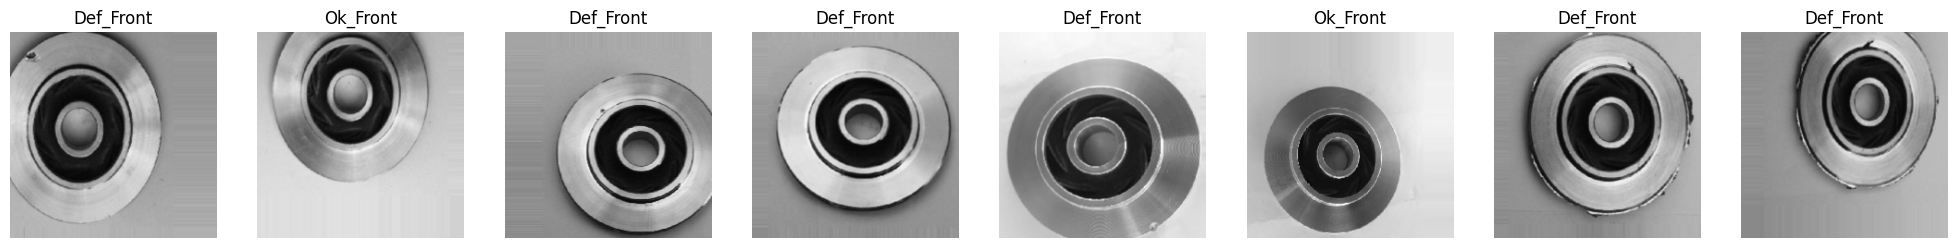

In [ ]:
CLASS_NAMES = np.array(['def_front','ok_front'], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,25))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

### ResNet152V2 Model

In [ ]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.4)(x)
output  = Dense(units=40, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 59,663,912 (227.60 MB)

 Trainable params: 6,851,624 (26.14 MB)

 Non-trainable params: 52,812,288 (201.46 MB)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define the ResNet152V2 base model
base_model = ResNet152V2(
    input_shape=(224, 224, 3),  # Input size (224x224 images with 3 channels for RGB)
    include_top=False,          # Exclude the top layer (use as a feature extractor)
    weights='imagenet'          # Use pre-trained weights from ImageNet
)

# Freeze the base model layers to prevent them from training initially
base_model.trainable = False


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import time
import datetime

# Prepare the base model
#base_model = ResNet152V2  # Pre-trained base model (e.g., MobileNetV2, ResNet50, etc.)

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Flatten the feature maps
    Dense(2, activation='softmax')  # Final output layer for 2 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Prepare the data generators
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    training_dir,  # Directory containing training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_gen = datagen.flow_from_directory(
    valid_dir,  # Directory containing validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Callbacks
now = datetime.datetime.now
t = now()

lrr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.4,
    min_lr=0.0001
)

NAME = "logs{}".format(int(time.time()))
tensorboard = TensorBoard(
    log_dir=f'/content/drive/MyDrive/Colab Notebooks/project_dataset/{NAME}'
)

checkpointer = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/project_dataset/Train/def_front/cast_def_0_2973.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto'
)

callbacks = [lrr, tensorboard, checkpointer]

# Compute steps per epoch
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

# Train the model
transfer_learning_history = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=150,
    verbose=1,
    callbacks=callbacks,
)

# Print statistics
print('Train data: ', STEP_SIZE_TRAIN)
print('Validation data: ', STEP_SIZE_VALID)
print(transfer_learning_history.history.keys())
print('Training time: %s' % (now() - t))


Found 1040 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.5632 - loss: 0.8206 - val_accuracy: 0.7188 - val_loss: 0.5116 - learning_rate: 0.0010
Epoch 2/150
 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.8125 - loss: 0.4497

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 643ms/step - accuracy: 0.8125 - loss: 0.4497 - val_accuracy: 0.8462 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.7914 - loss: 0.4390 - val_accuracy: 0.8125 - val_loss: 0.3984 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6875 - loss: 0.4877 - val_accuracy: 0.9615 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.8571 - loss: 0.3533 - val_accuracy: 0.8661 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.3996 - val_accuracy: 0.8846 - val_loss: 0.3221 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8703 - loss: 0.3129
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.8706 - loss: 0.3127 - val_ac

### Visualization accuracy and loss

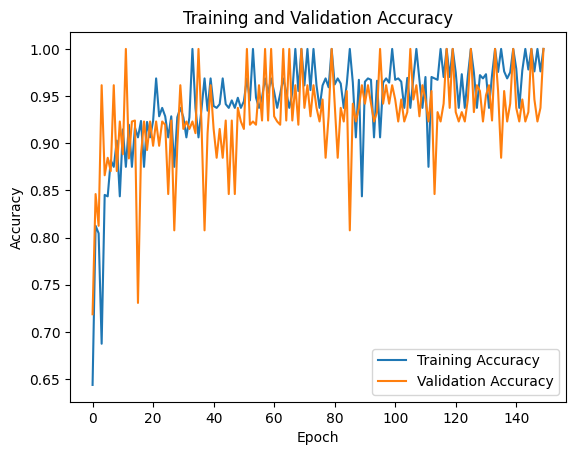

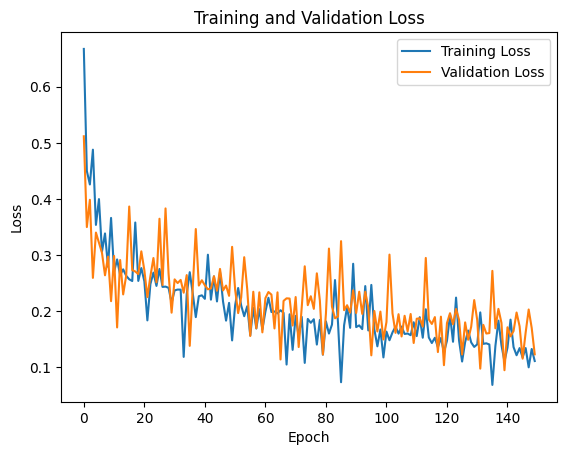

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Save Model

In [ ]:
def save_model_result(model):
	'''
		-- model : compiled model on the given data.
	'''

	# Extract model result data to separate data vectors
	data_val_acc = list(model.history.history['val_accuracy'])
	data_acc = list(model.history.history['accuracy'])
	data_val_loss = list(model.history.history['val_loss'])
	data_loss = list(model.history.history['loss'])

	# Convert Model result data to dataframe by using dictionary dat structure
	d = {}
	d['val_accuracy'] = data_val_acc
	d['accuracy'] = data_acc
	d['val_loss'] = data_val_loss
	d['loss'] = data_loss

	df = pd.DataFrame(d)
	print(df)

	# Get a current timestamp
	timestamp = str(datetime.datetime.now()).replace(":","-")[:-10].replace(' ', '_')
	filename = '/content/drive/MyDrive/Colab Notebooks/project_dataset/Train/History{}.csv'.format(timestamp)
	df.to_csv(filename, encoding='utf-8')

	print('\n\nResult data is saved as file: {}'.format(filename))

	return df

# Testing Custom

In [ ]:
from sklearn.datasets import load_files
from keras.utils import to_categorical  # Correct import
import numpy as np

def load_dataset(path):
    # Load the dataset from the specified path
    data = load_files(path)

    # Extract file paths and corresponding targets
    paths = np.array(data['filenames'])
    targets = to_categorical(np.array(data['target']))  # Use to_categorical directly

    return paths, targets

# Example usage
test_files, test_targets = load_dataset('/content/drive/MyDrive/Colab Notebooks/project_dataset/Test')


In [ ]:
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tqdm import tqdm

def path_to_tensor(img_path):
    #load image, resize ke ukuran 224,224
    img = image.load_img(img_path, target_size=(224, 224))
    #convert gambar jadi 3D tensor (224,224,3)
    x = image.img_to_array(img).astype(np.float32)/255
    # x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = (paths_to_tensor(test_files))

100%|██████████| 250/250 [00:01<00:00, 213.40it/s]


In [ ]:
!mkdir -p saved_model
tf.saved_model.save(model, 'saved_model/my_model')

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model
model.save('my_model.h5')

my_model
assets	fingerprint.pb	saved_model.pb	variables


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9506 - loss: 0.1616

Testing loss: 0.1647
Testing accuracy: 0.9440
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


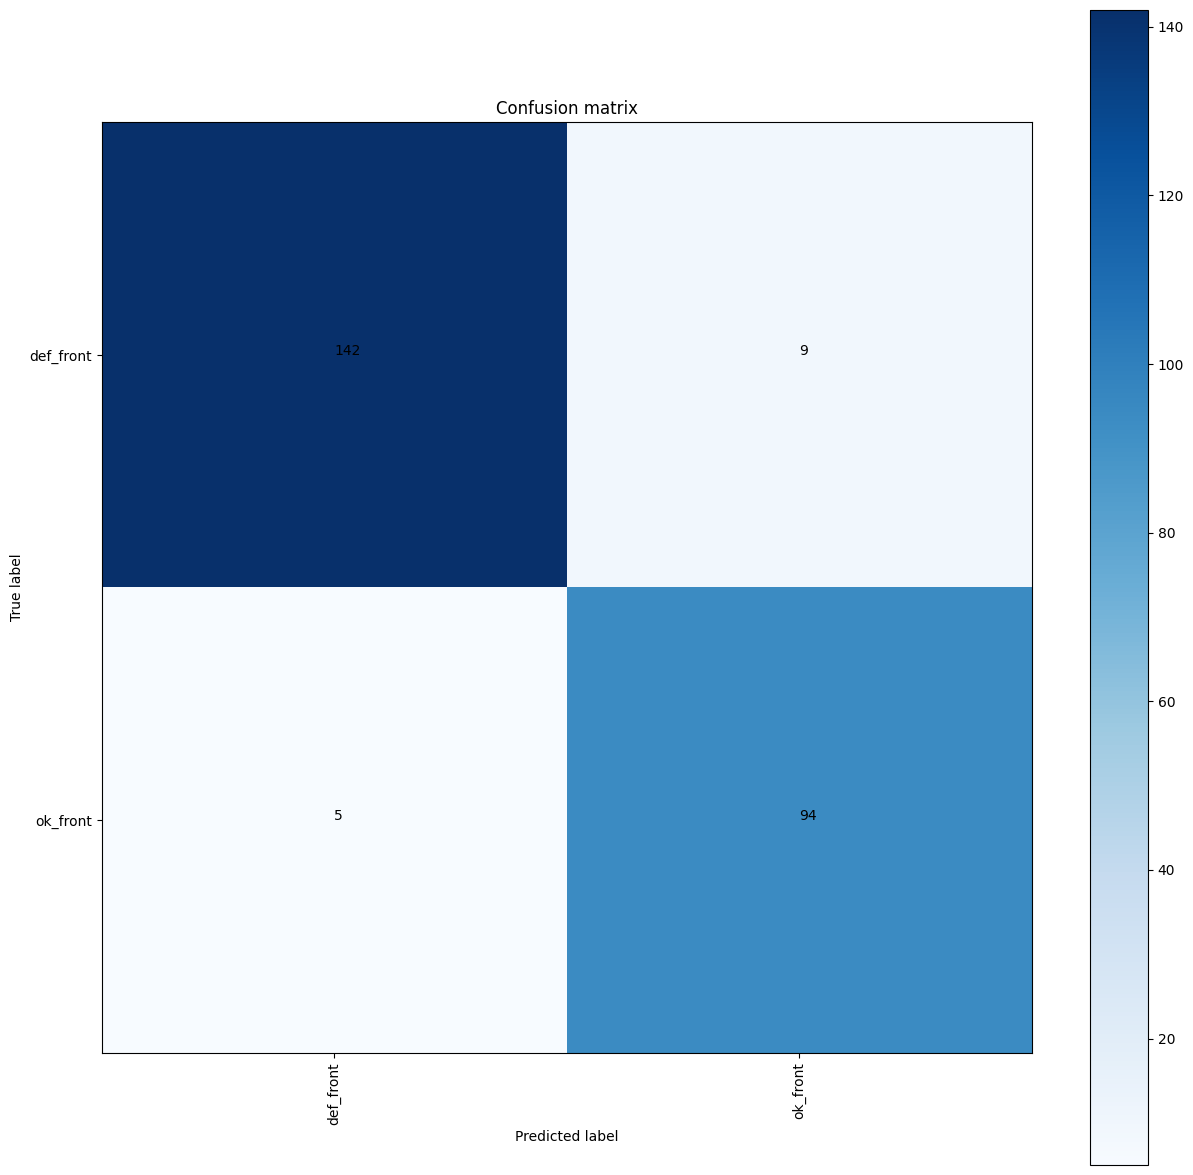

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')
result = print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_tensors, test_targets, batch_size=test_gen.batch_size)))

from sklearn.metrics import confusion_matrix
import numpy as np
fig, ax = plt.subplots(figsize=(15, 15))
#cm_labels = ['A full', 'A half', 'A seper16', 'A seper4', 'A seper8', 'B full', 'B half', 'B seper16', 'B seper4', 'B seper8', 'C full', 'C half', 'C seper16', 'C seper4', 'C seper8', "C' full", "C' half", "C' seper16", "C' seper4", "C' seper8", 'D full', 'D half', 'D seper16', 'D seper4', 'D seper8', 'E full', 'E half', 'E seper16', 'E seper4', 'E seper8', 'F full', 'F half', 'F seper16', 'F seper4', 'F seper8', 'G full', 'G half', 'G seper16', 'G seper4', 'G seper8']
cm_labels = ['def_front','ok_front']
cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test dataset directory
test_dir = '/content/drive/MyDrive/Colab Notebooks/project_dataset/Test'

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

# Load the trained model
model_resnet152 = load_model('my_model.h5')

# Generate predictions
Y_pred_resnet152 = model_resnet152.predict(test_generator, steps=test_generator.samples)
y_pred_resnet152 = np.argmax(Y_pred_resnet152, axis=1)

# Confusion Matrix and Classification Report
print('Confusion Matrix ResNet152')
print(confusion_matrix(test_generator.classes, y_pred_resnet152))

print('Classification Report')
target_names = ['def_front', 'ok_front']
print(classification_report(test_generator.classes, y_pred_resnet152, target_names=target_names))

# Evaluate model using the test data
x_test, y_test = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test = np.vstack(x_test)  # Combine all test images
y_test = np.vstack(y_test)  # Combine all test labels

loss_resnet152, acc_resnet152 = model_resnet152.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: ", acc_resnet152)
print("Loss: ", loss_resnet152)


Found 250 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
Confusion Matrix ResNet152
[[142   9]
 [  5  94]]
Classification Report
              precision    recall  f1-score   support

   def_front       0.97      0.94      0.95       151
    ok_front       0.91      0.95      0.93        99

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 593ms/step - accuracy: 0.9308 - loss: 0.1613
Accuracy:  0.9440000057220459
Loss:  0.16474702954292297
